In [1]:
import numpy as np
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, GRU
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import seaborn as sns
  
from sklearn.svm import SVC # for Support Vector Classification model
from sklearn.ensemble import RandomForestClassifier


import plotly.express as px  # for data visualization
import plotly.graph_objects as go # for data visualization

plt.style.use('default')
random.seed(123)

tnse comps = tsne_comps1 + tsne_comps2 #ictal and interictal

In [16]:
df = pd.read_excel('output.xlsx', index_col=0)

vecs_ictal = np.load('tsne_comps1.npy')
vecs_interictal = np.load('tsne_comps1_preictal.npy')

person_number = np.repeat(np.sort(df["patient_number"].to_numpy()),18)
labels_ictal = np.repeat(1,len(person_number))
labels_interictal = np.repeat(0, len(person_number))

(unique, counts) = np.unique(person_number, return_counts=True)
unique, counts

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 22, 23, 24]),
 array([198,  54, 126,  72,  90, 180,  54,  90,  72, 126,  54, 486, 216,
        144, 360, 180,  54, 108,  54, 144,  54, 126, 234]))

# Make a Overall Vector with shape (23, x, 18, 42)

## OBS: MAYBE NOT USEFUL AFTER ALL...


In [14]:
def all_vecs(array):
    i = 0
    all_vecs = []
    abxd = 0

    for j in range(len(unique)):
        temp_list = []
        for i in range(counts[j]):
            temp_list.append(array[abxd+i])
        abxd =+ counts[j]
        all_vecs.append(temp_list)
        
    all_vecs= np.asarray(all_vecs, dtype=object)
    return all_vecs

# 0 = interictal, 1 = ictal

In [4]:
def data_splitter(train_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], test_data=[23]):
    X_train, y_train, X_test, y_test = [], [], [], []

    for e, per in enumerate(person_number):
        if per in train_data:
            X_train.append(vecs_interictal[e])
            X_train.append(vecs_ictal[e])
            y_train.append(labels_interictal[e])
            y_train.append(labels_ictal[e])

        if per in test_data:
            X_test.append(vecs_interictal[e])
            X_test.append(vecs_ictal[e])
            y_test.append(labels_interictal[e])
            y_test.append(labels_ictal[e])
            
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), bbox_to_anchor=(1.04,1),  loc = "upper left", fontsize=15)
    
def fitting_SVM(train_data, test_data, C, gamma):
    # Create training and testing samples
    X_train, y_train,  X_test, y_test = data_splitter(train_data, test_data)

    # Fit the model
    # Note, available kernels: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
    model = SVC(kernel='rbf', probability=True, C=C, gamma=gamma)
    clf = model.fit(X_train, y_train)

    # Predict class labels on train data
    pred_labels_tr = model.predict(X_train)
    # Predict class labels on a test data
    pred_labels_te = model.predict(X_test)
    
    report = confusion_matrix(y_test, pred_labels_te)

    # Use score method to get accuracy of the model
    print('----- Evaluation on Test Data -----')
    score_te = model.score(X_test, y_test)
    print('Accuracy Score: ', score_te)
    # Look at classification report to evaluate the model
    print(classification_report(y_test, pred_labels_te))
    clf_report = classification_report(y_test, pred_labels_te, output_dict=True)
    print('--------------------------------------------------------')
    #report = classification_report(y_test, pred_labels_te, output_dict=True)

    print('----- Evaluation on Train Data-----')
    score_tr = model.score(X_train, y_train)
    print('Accuracy Score: ', score_tr)
    # Look at classification report to evaluate the model
    print(classification_report(y_train, pred_labels_tr))
    print('--------------------------------------------------------')
    
    # Return relevant data for chart plotting
    return X_train, X_test, y_train, y_test, clf, report, clf_report


def fitting_RF(train_data, test_data):
    # Create training and testing samples
    X_train, y_train,  X_test, y_test = data_splitter(train_data, test_data)

    # Fit the model
    # Note, available kernels: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
    model = RandomForestClassifier(n_estimators = 100)
    clf = model.fit(X_train, y_train)

    # Predict class labels on train data
    pred_labels_tr = model.predict(X_train)
    # Predict class labels on a test data
    pred_labels_te = model.predict(X_test)
    
    report = confusion_matrix(y_test, pred_labels_te)

    # Use score method to get accuracy of the model
    print('----- Evaluation on Test Data -----')
    score_te = model.score(X_test, y_test)
    print('Accuracy Score: ', score_te)
    # Look at classification report to evaluate the model
    print(classification_report(y_test, pred_labels_te))
    clf_report = classification_report(y_test, pred_labels_te)
    clf_report = pd.DataFrame(clf_report).transpose()
    print('--------------------------------------------------------')

    print('----- Evaluation on Train Data-----')
    score_tr = model.score(X_train, y_train)
    print('Accuracy Score: ', score_tr)
    # Look at classification report to evaluate the model
    print(classification_report(y_train, pred_labels_tr))
    print('--------------------------------------------------------')
    
    # Return relevant data for chart plotting
    return X_train, X_test, y_train, y_test, clf, report, clf_report


X_train, y_train, X_test, y_test = data_splitter()

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)




(5832, 2) (5832,) (252, 2) (252,)


In [17]:
accuracy_train = []
accuracy_test = []
conf_matrix_list_of_arrays = []

df = {"precision": [], "recall": [], "f1-score": [], "support": []}


for i in range(1,25):
    # Leave one out model 
    if i == 21:
        continue
    test_data = [i]
    
    train_data = [*range(1, 25, 1)]
    train_data.remove(21)
    train_data.remove(i)
    
    X_train, X_test, y_train, y_test, clf, report, clf_report = fitting_SVM(train_data, test_data, 1, 'scale')
    accuracy_train.append(clf.score(X_train, y_train))
    accuracy_test.append(clf.score(X_test,y_test))
    df["precision"].append(clf_report["0"]["precision"]), df["recall"].append(clf_report["0"]["recall"])
    df["f1-score"].append(clf_report["0"]["f1-score"]), df["support"].append(clf_report["0"]["support"])
    conf_matrix_list_of_arrays.append(report)
    cm = report 
    
    #ax= plt.subplot()
    #sns.heatmap(cm, annot=True, cmap="crest", fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    #ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels'); 
    #ax.set_title(f'Confusion Matrix for Patient {i}'); 
    #ax.xaxis.set_ticklabels(['Inter-Ictal', 'Ictal']); ax.yaxis.set_ticklabels(['Inter-Ictal', 'Ictal']);
    #plt.savefig(f'conf_matrix_p{i}.png')
    #plt.clf()



----- Evaluation on Test Data -----
Accuracy Score:  0.898989898989899
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       198
           1       0.92      0.87      0.90       198

    accuracy                           0.90       396
   macro avg       0.90      0.90      0.90       396
weighted avg       0.90      0.90      0.90       396

--------------------------------------------------------
----- Evaluation on Train Data-----
Accuracy Score:  0.9251137102014295
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      3078
           1       0.93      0.92      0.92      3078

    accuracy                           0.93      6156
   macro avg       0.93      0.93      0.93      6156
weighted avg       0.93      0.93      0.93      6156

--------------------------------------------------------
----- Evaluation on Test Data -----
Accuracy Score:  0.8425925925925926
              pre

In [19]:
np.mean([ a*100 for a in df['precision']])
## 10 seconds before annotation vs 4 seconds after 

90.10090991551297

In [12]:
[ a*100 for a in df['precision']] 
## 4 seconds before annotation

[93.43065693430657,
 70.0,
 78.88888888888889,
 92.3076923076923,
 79.36507936507937,
 79.3103448275862,
 85.0,
 74.02597402597402,
 91.30434782608695,
 79.51807228915662,
 75.51020408163265,
 94.6268656716418,
 88.31168831168831,
 91.83673469387756,
 87.36842105263159,
 78.94736842105263,
 84.44444444444444,
 88.37209302325581,
 87.87878787878788,
 96.22641509433963,
 85.1063829787234,
 73.91304347826086,
 82.53968253968253]

In [16]:
result_test, result_train ### 4 seconds after annotation 

([78.53535353535354,
  75.0,
  73.80952380952381,
  75.69444444444444,
  74.44444444444444,
  73.88888888888889,
  78.70370370370371,
  80.55555555555556,
  79.86111111111111,
  80.95238095238095,
  80.55555555555556,
  71.09053497942386,
  79.62962962962963,
  78.81944444444444,
  75.83333333333333,
  78.88888888888889,
  75.92592592592592,
  76.85185185185185,
  78.70370370370371,
  71.875,
  72.22222222222221,
  78.57142857142857,
  79.48717948717949],
 [77.14424951267057,
  77.1880819366853,
  77.23809523809524,
  77.20037453183521,
  77.22849968612681,
  77.24483204134367,
  77.1725636250776,
  77.04017576898933,
  77.02871410736579,
  76.93650793650794,
  77.01738050900062,
  77.59856630824373,
  77.00980392156863,
  76.9955300127714,
  77.400548696845,
  76.95413436692506,
  77.25015518311608,
  77.24116161616162,
  77.01738050900062,
  77.28288633461047,
  77.28119180633148,
  77.07936507936508,
  76.90664036817883])

In [8]:
np.mean(accuracy_train), np.mean(accuracy_test)

(0.7715029735203547, 0.7695217847995626)

In [10]:
np.mean(df['f1-score'])

0.7681399125746199

In [7]:
test_data = [1]

train_data = [*range(1, 24, 1)]
train_data.remove(1)

X_train, X_test, y_train, y_test, clf, report = fitting_SVM(train_data, test_data, 1, 'scale')
accuracy.append(clf.score(X_test,y_test))
conf_matrix_list_of_arrays.append(report)

----- Evaluation on Test Data -----
Accuracy Score:  0.7777777777777778
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       198
           1       0.79      0.76      0.77       198

    accuracy                           0.78       396
   macro avg       0.78      0.78      0.78       396
weighted avg       0.78      0.78      0.78       396

--------------------------------------------------------
----- Evaluation on Train Data-----


KeyboardInterrupt: 

Accuracy:  76.95, Sensitivity:  74.65, Specificity:  78.17


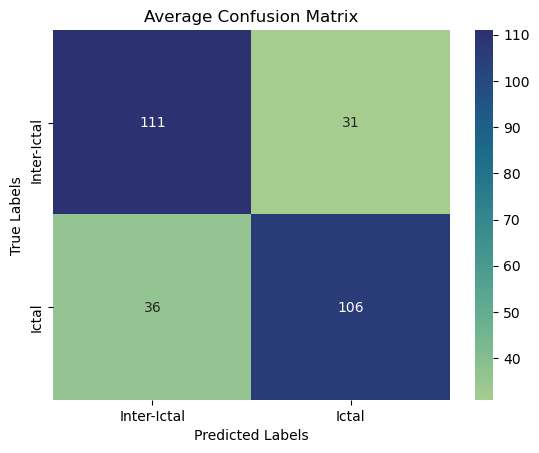

In [11]:
mean_of_conf_matrix_arrays = (np.mean(conf_matrix_list_of_arrays, axis=0))
cm = mean_of_conf_matrix_arrays.astype(int)

ax= plt.subplot()
sns.heatmap(cm, annot=True, cmap="crest", fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels'); 
ax.set_title('Average Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Inter-Ictal', 'Ictal']); ax.yaxis.set_ticklabels(['Inter-Ictal', 'Ictal']);

acc = np.mean(accuracy_test)*100
mean_cm = mean_of_conf_matrix_arrays.astype(int)
TP, TN, FN, FP = mean_cm[1][1], mean_cm[0][0], mean_cm[1][0], mean_cm[0][1]



sensitivity = (TP/(TP+FN))*100
specificity = (TN/(TN+FP))*100

print(f"Accuracy: {acc: .2f}, Sensitivity: {sensitivity: .2f}, Specificity: {specificity: .2f}")


In [146]:
accuracy = []
conf_matrix_list_of_arrays = []


for i in range(1,24):
    # Leave one out model 
    test_data = [i]
    
    train_data = [*range(1, 24, 1)]
    train_data.remove(i)
    
    X_train, X_test, y_train, y_test, clf, report = fitting_RF(train_data, test_data)
    accuracy.append(clf.score(X_test,y_test))
    conf_matrix_list_of_arrays.append(report)


    


----- Evaluation on Test Data -----
Accuracy Score:  0.8763888888888889
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       360
           1       0.91      0.83      0.87       360

    accuracy                           0.88       720
   macro avg       0.88      0.88      0.88       720
weighted avg       0.88      0.88      0.88       720

--------------------------------------------------------
----- Evaluation on Train Data-----
Accuracy Score:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2916
           1       1.00      1.00      1.00      2916

    accuracy                           1.00      5832
   macro avg       1.00      1.00      1.00      5832
weighted avg       1.00      1.00      1.00      5832

--------------------------------------------------------
----- Evaluation on Test Data -----
Accuracy Score:  0.9166666666666666
              precision    reca

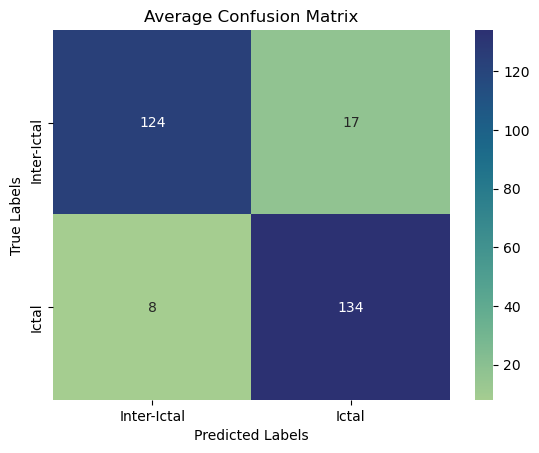

In [25]:
mean_of_conf_matrix_arrays = (np.mean(conf_matrix_list_of_arrays, axis=0))
cm = mean_of_conf_matrix_arrays.astype(int)

ax= plt.subplot()
sns.heatmap(cm, annot=True, cmap="crest", fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels'); 
ax.set_title('Average Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Inter-Ictal', 'Ictal']); ax.yaxis.set_ticklabels(['Inter-Ictal', 'Ictal']);

#acc = np.mean(accuracy)
mean_cm = mean_of_conf_matrix_arrays.astype(int)
TP, TN, FN, FP = mean_cm[1][1], mean_cm[0][0], mean_cm[1][0], mean_cm[0][1]



sensitivity = TP/(TP+FN)
specificity = TN/(TN+FP)

#print(f"Accuracy: {acc: .2f}, Sensitivity: {sensitivity: .2f}, Specificity: {specificity: .2f}")
plt.savefig('filename.png')
